# Gaertner L116A Ellipsometer

**Scott Prahl**

**May 2020**

**Version 3**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pypolar.ellipsometry as ell
import pypolar.gaertner as gaertner

## Hardware

This only of interest to the Oregon Tech students.

Our Gaertner L116A ellipsometer was made in 1978.  Since the computer that was attached to this ellipsometer is long gone, we programmed an Arduino to serve as its computer interface.  The Arduino collects 72 data points from one rotation of the ellipsometer analyzer.  This array is sent over the USB serial connection to a host computer running a Jupyter notebook.

<img src="https://omlc.org/~prahl/host/453/week3/ellipsometer.jpg" width="50%">

## Optical Elements

<img src="https://omlc.org/~prahl/host/453/week3/image-A-0014.png" width="50%">

### Establishing a connection to the ellipsometer

You must establish serial communication between your computer and the Arduino.
**To do this you need to know the name of the serial connection.**

One way to figure our the right name is to list the current serial ports on your computer:  `gaerter.current_serial_ports()` returns such a list.

Of course, if the ellipsometer is not plugged into the computer then the proper serial port will not appear.

In [2]:
s = gaertner.current_serial_ports()
print(s)

                           portname  info
    /dev/cu.Bluetooth-Incoming-Port  n/a
       /dev/cu.Rasputin-WirelessiAP  n/a
  /dev/cu.RaspustinsAirPods-Wirel-1  n/a
    /dev/cu.RaspustinsOldAirPods-Wi  n/a
  /dev/cu.RaspustinsOldAirPods-Wi-1  n/a
              /dev/cu.usbmodemFA141  Arduino Uno



In [4]:
### Identify the port that is connected to the Arduino
### Copy that portname and port connected to the Ardunio string from above as the correct serial port id below

id = '/dev/cu.usbmodemFA141'   # UPDATE ME

conn = gaertner.connect_to_ellipsometer(id)

### Obtaining a signal

To acquire 72 equally spaced measurements as the analyzer is rotated, just do
```
signal=get_reflectance(conn)
```

## 30 degrees

saved data to file named 'glass, I=30.0°, P=45.0°, QWP=False, 2020-05-04-15-46-52.txt'
(0.10236144286158197-0.57699303825475j)


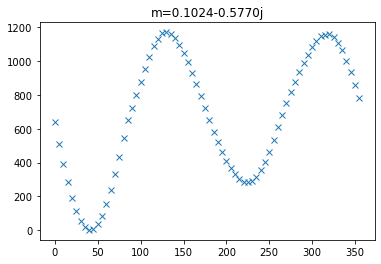

In [10]:
#glass
P = np.radians(45)
degrees = np.linspace(0,360,num=72,endpoint=False)
phi = np.radians(degrees)
theta_i = np.radians(30)

signal = gaertner.avg_reflectance(conn)
rho = ell.rho_from_rotating_analyzer_data(phi, signal, P, QWP=False)

gaertner.save_data_with_name(signal, "glass", theta_i, P, QWP=False)
m = ell.m_from_rho(rho,theta_i)

plt.plot(degrees,signal,'x')
plt.title("m=%.4f%+.4fj" % (m.real,m.imag))
plt.show()

saved data to file named 'glass, I=30.0°, P=0.0°, QWP=True, 2020-05-04-14-39-44.txt'
(3.422876969391375-1.6343693218676805j)


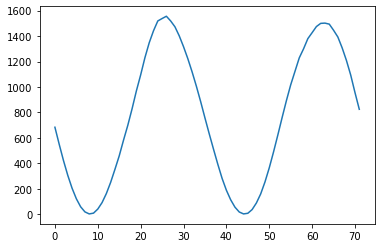

In [42]:
P = np.radians(0)
degrees = np.linspace(0,360,num=72,endpoint=False)
phi = np.radians(degrees)
theta_i = np.radians(30)

signal = gaertner.get_reflectance(conn)
rho = ell.rho_from_rotating_analyzer_data(phi, signal, P, QWP=True)

gaertner.save_data_with_name(signal, "glass", np.degrees(theta_i), np.degrees(P), QWP=True)
m = ell.m_from_rho(rho,theta_i)

print(m)
plt.plot(signal)
plt.show()

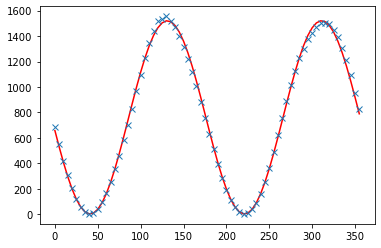

In [45]:
I_0, alpha, beta = ell.find_fourier(phi,signal)
fitted_signal = I_0*(1+alpha*np.cos(2*phi)+beta*np.sin(2*phi))

plt.plot(np.degrees(phi),fitted_signal, color='red')


plt.plot(np.degrees(phi),signal,'x')
plt.show()

In [34]:
#silicon

P = np.radians(45)
degrees = np.linspace(0,360,num=72,endpoint=False)
phi = np.radians(degrees)
theta_i = np.radians(30)

signal = gaertner.avg_reflectance(conn)
rho = ell.rho_from_rotating_analyzer_data(phi, signal, P, QWP=False)

gaertner.save_data_with_name(signal, "silicon", np.degrees(theta_i), np.degrees(P), QWP=False)
m = ell.m_from_rho(rho,theta_i)
print(m)

saved data to file named 'silicon, I=30.0°, P=45.0°, QWP=False, 2020-05-04-14-35-34.txt'
(0.15251051516130495-0.41054419900566863j)


In [25]:
P = np.radians(0)
degrees = np.linspace(0,360,num=72,endpoint=False)
phi = np.radians(degrees)
theta_i = np.radians(30)

signal = gaertner.avg_reflectance(conn)
rho = ell.rho_from_rotating_analyzer_data(phi, signal, P, QWP=True)

gaertner.save_data_with_name(signal, "siliconv", np.degrees(theta_i), np.degrees(P), QWP=True)
m = ell.m_from_rho(rho,theta_i)
print(m)

Bad number of bytes read (0 != 144)
Make sure ellipsometer is rotating!


UFuncTypeError: Cannot cast ufunc 'add' output from dtype('float64') to dtype('int64') with casting rule 'same_kind'